# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate

# Configs

In [2]:
LABELED_PATH = 'data/pair_labels.parquet'
XGB_MODEL_PATH = 'results/pairs_xgb_predictions.parquet'
REGRESSION_MODEL_PATH = 'results/pairs_ridge_predictions.parquet'
RF_MODEL_PATH = 'results/pairs_rf_predictions.parquet'

SAVE_PLOT_PATH = 'svg/'

MODEL_LIST = ['BASELINE_LAST_WEEK', 'REGRESSION_MODEL', 'XGB_MODEL', 'RF_MODEL']
CATEGORIES = ['high_demand_pair_locations','low_demand_pair_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['PULocation', 'Date', 'Day_of_week']



TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'

HIGH_DEMAND_NUMS = 197

SORT_METHODE = 'mean'

warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [4]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(173160, 4)


,PULocation,Date,DOLocation,Demand
0,13,2023-01-01,68,20.0
1,13,2023-01-02,68,19.0
2,13,2023-01-03,68,16.0
3,13,2023-01-04,68,22.0
4,13,2023-01-05,68,31.0


In [5]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df.head()

,PULocation,Date,DOLocation,Demand
0,13,2023-04-01,68,18.0
1,13,2023-04-02,68,16.0
2,13,2023-04-03,68,24.0
3,13,2023-04-04,68,31.0
4,13,2023-04-05,68,32.0


## Load Predicted Data

In [6]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of REGRESSION_MODEL (43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-04-01,68,22.153462
1,13,2023-04-02,68,18.887359
2,13,2023-04-03,68,23.965120
3,13,2023-04-04,68,33.974492
4,13,2023-04-05,68,33.842866


shape of XGB_MODEL (43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-04-01,68,21.043465
1,13,2023-04-02,68,17.703024
2,13,2023-04-03,68,24.283808
3,13,2023-04-04,68,29.548220
4,13,2023-04-05,68,30.430885


shape of RF_MODEL (43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-04-01,68,21.724972
1,13,2023-04-02,68,19.620236
2,13,2023-04-03,68,24.774499
3,13,2023-04-04,68,31.374873
4,13,2023-04-05,68,30.496435


### BaseLine Models

In [7]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['PULocation', 'DOLocation'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['PULocation', 'Date', 'DOLocation']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [8]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
7,13,2023-04-01,68,15.0
8,13,2023-04-02,68,21.0
9,13,2023-04-03,68,21.0
10,13,2023-04-04,68,32.0
11,13,2023-04-05,68,37.0


### Join Predictions and Actual

In [9]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['PULocation', 'Date', 'DOLocation'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [10]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (43290, 6)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,18.0,15.0,5
1,13,2023-04-02,68,16.0,21.0,6
2,13,2023-04-03,68,24.0,21.0,0
3,13,2023-04-04,68,31.0,32.0,1
4,13,2023-04-05,68,32.0,37.0,2


shape of predictions_dict[REGRESSION_MODEL]: (43290, 6)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,18.0,22.153462,5
1,13,2023-04-02,68,16.0,18.887359,6
2,13,2023-04-03,68,24.0,23.965120,0
3,13,2023-04-04,68,31.0,33.974492,1
4,13,2023-04-05,68,32.0,33.842866,2


shape of predictions_dict[XGB_MODEL]: (43290, 6)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,18.0,21.043465,5
1,13,2023-04-02,68,16.0,17.703024,6
2,13,2023-04-03,68,24.0,24.283808,0
3,13,2023-04-04,68,31.0,29.548220,1
4,13,2023-04-05,68,32.0,30.430885,2


shape of predictions_dict[RF_MODEL]: (43290, 6)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,18.0,21.724972,5
1,13,2023-04-02,68,16.0,19.620236,6
2,13,2023-04-03,68,24.0,24.774499,0
3,13,2023-04-04,68,31.0,31.374873,1
4,13,2023-04-05,68,32.0,30.496435,2


### Sort Locations by Demand

In [11]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        sorted_index = predictions_df.groupby(['PULocation','DOLocation'])['Demand'].aggregate([SORT_METHODE]).sort_values(SORT_METHODE, ascending=False)
        sorted_index = sorted_index.reset_index()
        sorted_locations_dict['high_demand_pair_locations'] = sorted_index[:HIGH_DEMAND_NUMS]
        sorted_locations_dict['low_demand_pair_locations'] = sorted_index[HIGH_DEMAND_NUMS:]
        

In [12]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_pair_locations]: (197, 3)


,PULocation,DOLocation,mean
0,264,264,1050.233333
1,237,236,756.900000
2,236,237,636.166667
3,237,237,500.333333
4,236,236,496.033333


shape of sorted_locations_dict[low_demand_pair_locations]: (1246, 3)


,PULocation,DOLocation,mean
197,140,141,104.166667
198,239,161,103.900000
199,234,230,103.400000
200,162,164,103.366667
201,230,236,103.266667


# Mean error Calculation

### Error Columns

In [13]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [14]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (43290, 9)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,18.0,15.0,5,3.0,9.0,16.666667
1,13,2023-04-02,68,16.0,21.0,6,5.0,25.0,31.250000
2,13,2023-04-03,68,24.0,21.0,0,3.0,9.0,12.500000
3,13,2023-04-04,68,31.0,32.0,1,1.0,1.0,3.225806
4,13,2023-04-05,68,32.0,37.0,2,5.0,25.0,15.625000


shape of predictions_dict[REGRESSION_MODEL]: (43290, 9)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,18.0,22.153462,5,4.153462,17.251244,23.074787
1,13,2023-04-02,68,16.0,18.887359,6,2.887359,8.336842,18.045993
2,13,2023-04-03,68,24.0,23.965120,0,0.034880,0.001217,0.145335
3,13,2023-04-04,68,31.0,33.974492,1,2.974492,8.847605,9.595137
4,13,2023-04-05,68,32.0,33.842866,2,1.842866,3.396155,5.758957


shape of predictions_dict[XGB_MODEL]: (43290, 9)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,18.0,21.043465,5,3.043465,9.262677,16.908137
1,13,2023-04-02,68,16.0,17.703024,6,1.703024,2.900290,10.643899
2,13,2023-04-03,68,24.0,24.283808,0,0.283808,0.080547,1.182532
3,13,2023-04-04,68,31.0,29.548220,1,1.451780,2.107666,4.683162
4,13,2023-04-05,68,32.0,30.430885,2,1.569115,2.462121,4.903483


shape of predictions_dict[RF_MODEL]: (43290, 9)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,18.0,21.724972,5,3.724972,13.875414,20.694287
1,13,2023-04-02,68,16.0,19.620236,6,3.620236,13.106106,22.626472
2,13,2023-04-03,68,24.0,24.774499,0,0.774499,0.599849,3.227079
3,13,2023-04-04,68,31.0,31.374873,1,0.374873,0.140530,1.209267
4,13,2023-04-05,68,32.0,30.496435,2,1.503565,2.260708,4.698641


### Aggregate Error Columns

In [15]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):

    for model,actual_predicted_df in actual_predicted_dict.items():
        
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['PULocation','DOLocation']], on=['PULocation','DOLocation'])
                
                for per in BASED_ON:
                    
                    if per!='PULocation':
                        categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                        categorized_mean_df = (
                            categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                                  mae=('error','mean'),
                                                                  mse=('squared_error','mean'),
                                                                  demand_mean=('Demand','mean'))
                                                                  ) 
                        categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                        categorized_mean_df.drop(columns='mse', inplace=True)
                        categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                        
                    else:
                        categorized_error_df = categorized_df[['PULocation','DOLocation','Demand','error','squared_error', 'percentage_error']]
                        categorized_mean_df = (
                            categorized_error_df.groupby(['PULocation','DOLocation']).agg(mape=('percentage_error','mean'),
                                                                  mae=('error','mean'),
                                                                  mse=('squared_error','mean'),
                                                                  demand_mean=('Demand','mean'))
                                                                  ) 
                        categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                        categorized_mean_df.drop(columns=['mse'], inplace=True)
                        categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                        loc_demand_index = sorted_locations.groupby(['PULocation','DOLocation'])[SORT_METHODE].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)

                    
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()


In [16]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_error_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][PULocation][high_demand_pair_locations]: (197, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,10.428586,108.300000,1050.233333,131.543276
1,237,236,11.088315,87.233333,756.900000,115.142665
2,236,237,12.083697,78.333333,636.166667,103.263740
3,237,237,11.885691,61.266667,500.333333,78.576926
4,236,236,14.631619,76.433333,496.033333,96.837149


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][PULocation][low_demand_pair_locations]: (1246, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,140,141,20.089570,20.300000,104.166667,24.605555
1,239,161,18.028051,17.133333,103.900000,19.825909
2,234,230,20.989382,19.700000,103.400000,26.387497
3,162,164,8.620142,8.000000,103.366667,10.013324
4,230,236,17.431495,17.533333,103.266667,20.612294


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,12.431600,17.538071,154.208122,22.387791
1,2023-04-02,14.814474,20.045685,129.482234,29.157110
2,2023-04-03,15.113781,22.502538,157.020305,32.394068
3,2023-04-04,12.192781,22.705584,175.050761,39.057617
4,2023-04-05,15.068682,30.015228,192.380711,45.782702


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Date][low_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,20.435092,8.569021,49.421348,11.509470
1,2023-04-02,21.445316,7.786517,41.591493,10.213138
2,2023-04-03,23.874887,7.932584,38.191814,10.504146
3,2023-04-04,21.825092,7.975923,42.840289,10.530091
4,2023-04-05,21.852359,8.971910,45.605939,12.436903


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,15.126383,22.496193,154.667513,32.402431
1,1,13.171211,23.173858,180.101523,34.160249
2,2,13.682227,24.883249,190.064721,36.017410
3,3,14.529885,24.586294,186.822335,33.502671
4,4,16.508313,28.137056,174.972081,39.396977


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Day_of_week][low_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,23.989939,7.710273,37.858146,10.387380
1,1,22.319107,8.102729,43.555177,10.711169
2,2,22.284309,8.865770,46.099719,11.994908
3,3,21.870903,9.069222,47.888844,12.117643
4,4,23.180176,9.586677,47.557384,12.657927


shape of predictions_mean_error_dict[REGRESSION_MODEL][PULocation][high_demand_pair_locations]: (197, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,7.331516,78.852151,1050.233333,100.465799
1,237,236,9.901558,76.033140,756.900000,96.160887
2,236,237,10.423796,67.065598,636.166667,83.248636
3,237,237,9.538576,47.491625,500.333333,58.967443
4,236,236,11.021696,57.169159,496.033333,73.532834


shape of predictions_mean_error_dict[REGRESSION_MODEL][PULocation][low_demand_pair_locations]: (1246, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,140,141,14.185804,14.182110,104.166667,18.352603
1,239,161,15.690499,14.672369,103.900000,18.285549
2,234,230,14.636114,13.845295,103.400000,17.174499
3,162,164,10.121342,8.744277,103.366667,10.640784
4,230,236,15.215772,14.657683,103.266667,18.498292


shape of predictions_mean_error_dict[REGRESSION_MODEL][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,11.093454,15.590455,154.208122,21.568895
1,2023-04-02,15.010190,16.458438,129.482234,21.235495
2,2023-04-03,13.711693,21.329303,157.020305,32.791730
3,2023-04-04,10.639181,19.165698,175.050761,30.058762
4,2023-04-05,13.598173,26.968964,192.380711,39.127623


shape of predictions_mean_error_dict[REGRESSION_MODEL][Date][low_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,17.803275,6.740085,49.421348,8.803528
1,2023-04-02,20.485498,7.077555,41.591493,9.260864
2,2023-04-03,25.623061,7.204587,38.191814,9.397922
3,2023-04-04,18.412626,6.535246,42.840289,8.773409
4,2023-04-05,20.103267,7.630273,45.605939,10.272283


shape of predictions_mean_error_dict[REGRESSION_MODEL][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,13.291875,19.530100,154.667513,27.965885
1,1,9.988915,17.082977,180.101523,24.070150
2,2,9.977367,18.294005,190.064721,26.889767
3,3,11.587224,20.254167,186.822335,28.142202
4,4,12.526217,20.919776,174.972081,28.661775


shape of predictions_mean_error_dict[REGRESSION_MODEL][Day_of_week][low_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,24.797793,6.919708,37.858146,9.038513
1,1,18.123441,6.412744,43.555177,8.423878
2,2,18.277059,6.882718,46.099719,9.087075
3,3,17.385706,7.207898,47.888844,9.564361
4,4,18.862030,7.729544,47.557384,10.134455


shape of predictions_mean_error_dict[XGB_MODEL][PULocation][high_demand_pair_locations]: (197, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,12.156227,137.862734,1050.233333,177.706883
1,237,236,9.582957,72.286727,756.900000,85.102948
2,236,237,10.928234,69.089292,636.166667,80.393797
3,237,237,10.015816,52.096547,500.333333,65.385898
4,236,236,12.219314,63.277514,496.033333,75.206928


shape of predictions_mean_error_dict[XGB_MODEL][PULocation][low_demand_pair_locations]: (1246, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,140,141,14.440174,14.437175,104.166667,18.553776
1,239,161,13.928288,13.617811,103.900000,17.154335
2,234,230,12.780995,12.176119,103.400000,14.818304
3,162,164,10.712698,10.212676,103.366667,11.093239
4,230,236,14.317323,13.954626,103.266667,18.053425


shape of predictions_mean_error_dict[XGB_MODEL][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,10.010545,14.728258,154.208122,24.146619
1,2023-04-02,11.773219,14.057420,129.482234,19.644393
2,2023-04-03,12.474095,19.162494,157.020305,28.282574
3,2023-04-04,9.850659,17.676993,175.050761,26.967882
4,2023-04-05,12.543424,24.413601,192.380711,33.456062


shape of predictions_mean_error_dict[XGB_MODEL][Date][low_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,15.782606,5.767355,49.421348,7.405608
1,2023-04-02,18.467640,6.416487,41.591493,8.238304
2,2023-04-03,19.432741,6.245051,38.191814,8.368918
3,2023-04-04,17.161742,6.268999,42.840289,8.307516
4,2023-04-05,17.774972,7.005776,45.605939,9.378570


shape of predictions_mean_error_dict[XGB_MODEL][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,13.004638,19.046055,154.667513,26.821526
1,1,9.924882,17.229444,180.101523,24.707664
2,2,9.319375,17.311016,190.064721,24.381500
3,3,11.154248,20.263006,186.822335,30.206762
4,4,12.738875,22.141882,174.972081,31.664207


shape of predictions_mean_error_dict[XGB_MODEL][Day_of_week][low_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,20.906507,6.278886,37.858146,8.281719
1,1,17.194117,6.126267,43.555177,7.956320
2,2,16.458913,6.306043,46.099719,8.237079
3,3,16.063589,6.593652,47.888844,8.651470
4,4,17.415813,7.127879,47.557384,9.390968


shape of predictions_mean_error_dict[RF_MODEL][PULocation][high_demand_pair_locations]: (197, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,10.793071,123.174880,1050.233333,164.416754
1,237,236,11.224048,79.990071,756.900000,91.303773
2,236,237,10.341667,65.324488,636.166667,75.821802
3,237,237,8.699551,44.324493,500.333333,57.567124
4,236,236,10.381017,54.529142,496.033333,71.003444


shape of predictions_mean_error_dict[RF_MODEL][PULocation][low_demand_pair_locations]: (1246, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,140,141,14.080714,13.975119,104.166667,18.061273
1,239,161,15.676081,14.575711,103.900000,17.982991
2,234,230,13.901067,13.110694,103.400000,16.030038
3,162,164,10.820686,9.801717,103.366667,11.400625
4,230,236,14.855268,14.277765,103.266667,18.259802


shape of predictions_mean_error_dict[RF_MODEL][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,10.401465,15.036687,154.208122,24.065890
1,2023-04-02,13.726566,15.353075,129.482234,20.774653
2,2023-04-03,12.614794,19.654926,157.020305,29.120979
3,2023-04-04,9.955638,17.875963,175.050761,27.423288
4,2023-04-05,12.402052,24.222215,192.380711,33.790274


shape of predictions_mean_error_dict[RF_MODEL][Date][low_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,16.549063,6.050956,49.421348,7.788037
1,2023-04-02,19.866484,6.729144,41.591493,8.767876
2,2023-04-03,21.294551,6.487602,38.191814,8.579469
3,2023-04-04,17.572449,6.284548,42.840289,8.367634
4,2023-04-05,18.510516,7.111903,45.605939,9.554979


shape of predictions_mean_error_dict[RF_MODEL][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,12.613745,18.473781,154.667513,26.061854
1,1,9.694655,16.544525,180.101523,23.234660
2,2,9.029399,16.434299,190.064721,23.466406
3,3,10.827639,19.253104,186.822335,28.548584
4,4,12.679199,21.677006,174.972081,31.055048


shape of predictions_mean_error_dict[RF_MODEL][Day_of_week][low_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,22.427155,6.472471,37.858146,8.473978
1,1,17.542259,6.161205,43.555177,8.037075
2,2,17.034532,6.413235,46.099719,8.413319
3,3,16.559468,6.699780,47.888844,8.822590
4,4,18.113852,7.343468,47.557384,9.688217


### Plot Mape for Models Predicted Demands

In [17]:
def plot(predictions_mean_dict, per):
        fig, axes = plt.subplots(nrows=len(CATEGORIES)*len(METRICS), ncols=1, figsize=(15,20))
        for i, met in enumerate(METRICS):
            for j, cat in enumerate(CATEGORIES):
                for model,mean_df in predictions_mean_dict.items():
                    categorized_demand_df = mean_df[per][cat]
                    if (categorized_demand_df is not None):
                        if per!='PULocation':
                            categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                            categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
                        else:
                            categorized_demand_df['pair_locations'] = [(a,b) for a,b in zip(categorized_demand_df['PULocation'],categorized_demand_df['DOLocation'])]
                            categorized_demand_df['pair_locations'] = categorized_demand_df['pair_locations'].astype(str)
                            categorized_demand_df.plot(x='pair_locations',y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
                
                axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+cat, bbox=dict( alpha=0.5))
                axes[len(CATEGORIES)*i+j].legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


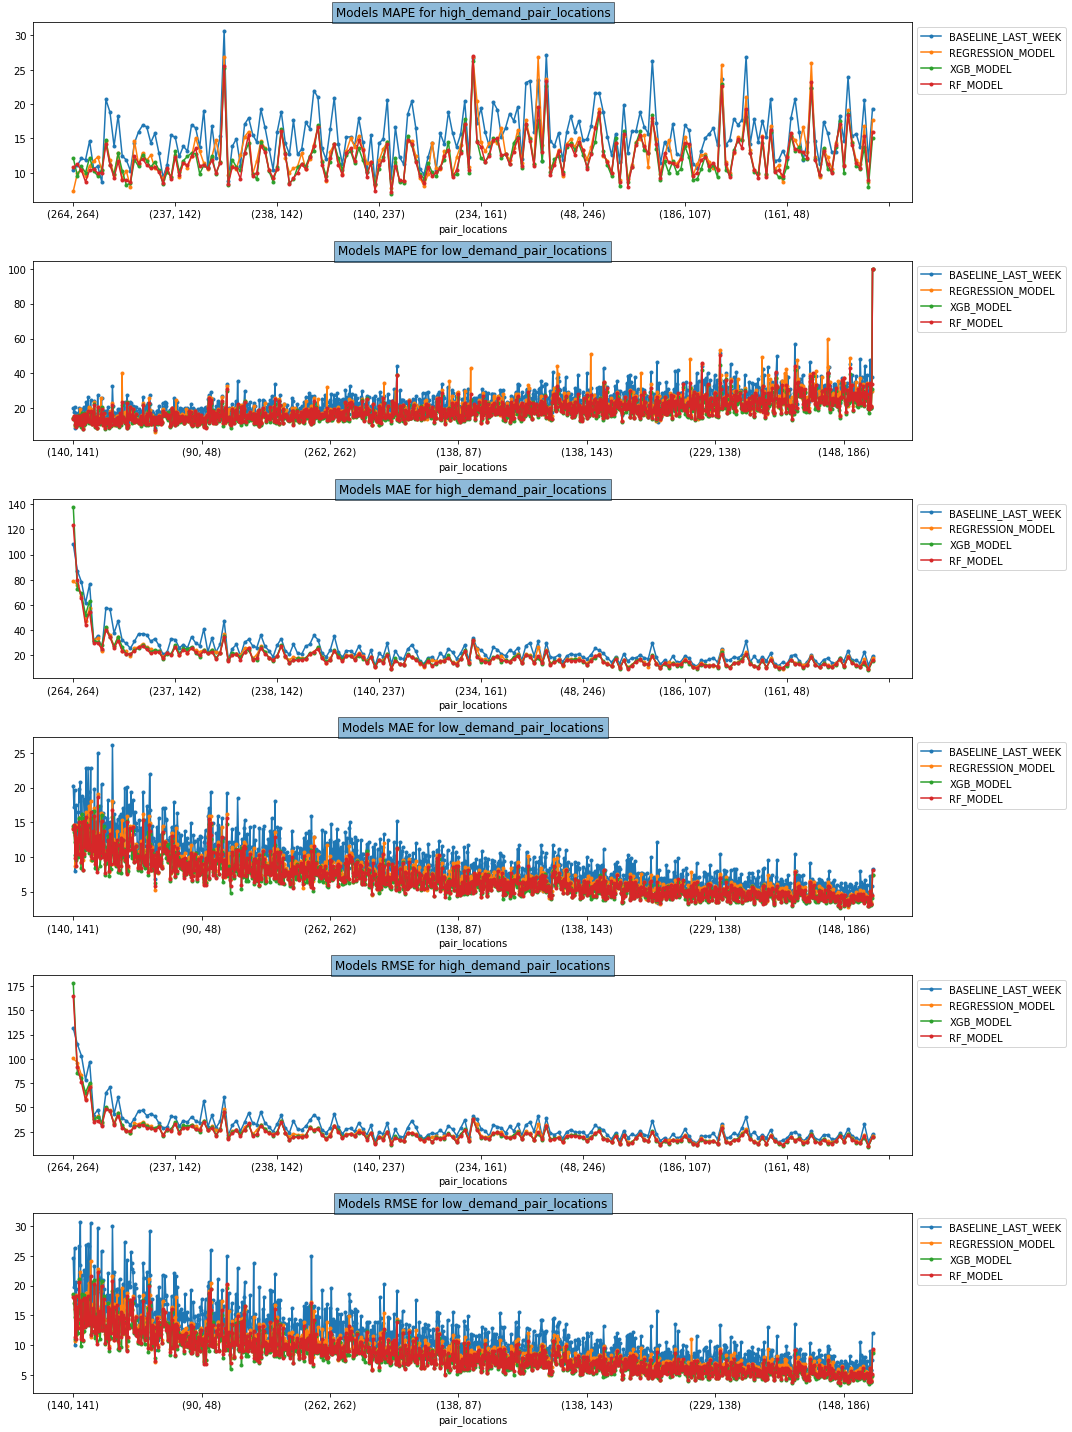

In [18]:
plot(predictions_mean_error_dict, 'PULocation')

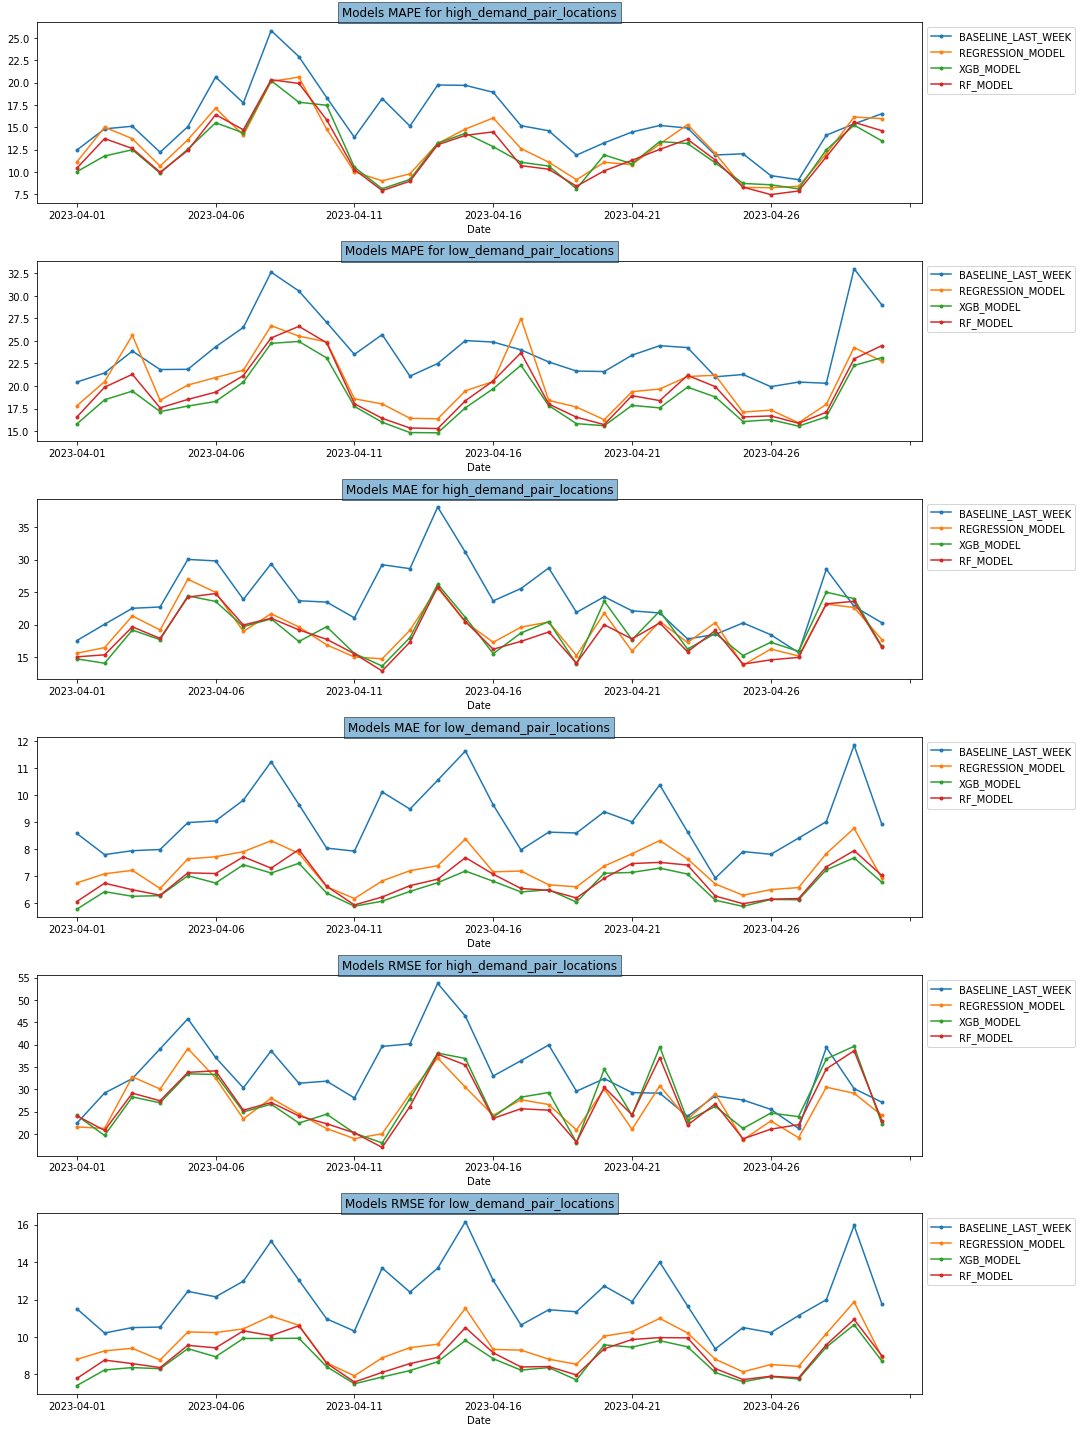

In [19]:
plot(predictions_mean_error_dict, 'Date')

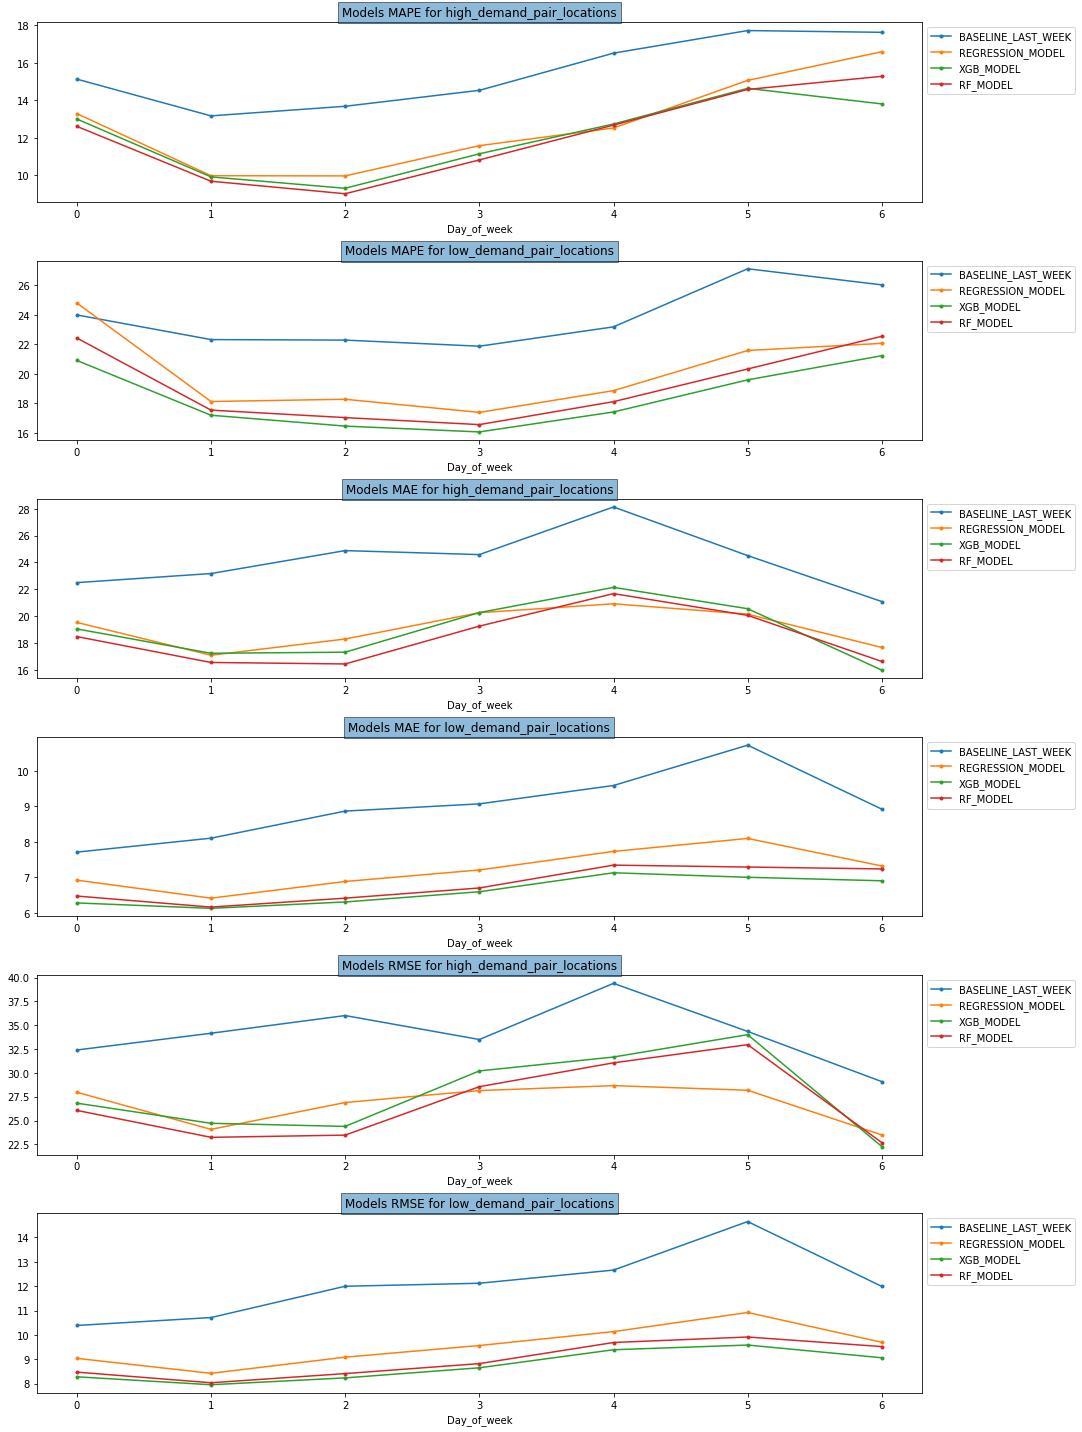

In [20]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [21]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['PULocation','DOLocation']]
                categorized_df = error_df.merge(sorted_index, on=['PULocation','DOLocation'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [22]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [23]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES,METRICS], names=['PULocation CATEGORIES:', 'Error Metrics:']))


In [24]:
df.style.format('{:.2f}')